# **Libraries**

In [ ]:
!pip install open-clip-torch --quiet
!pip install ftfy regex tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Standard library
import os
import warnings
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor

# Deep learning (TensorFlow/Keras)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# OpenCLIP (vision-language model)
import torch
import open_clip
from torchvision import transforms


In [ ]:
warnings.filterwarnings("ignore")

# **Data Import**

In [ ]:
# Import the dataset that we will work with
cols = ["property_id", "street_address", "city", "city_encoded",
        "num_bedrooms", "num_bathrooms", "square_feet", "price",
        "image_filename"]
df = pd.read_csv('Property_listings.csv', names= cols)
# Drop the first row as it contains coloumn names and reset the index to
# make sure the models read it as coloumn names

df = df.iloc[1:].reset_index(drop=True)


# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())



First 5 rows of the dataset:
  property_id         street_address          city city_encoded num_bedrooms  \
0           1         124 C Street W   Brawley, CA           48            3   
1           4  2207 R Carrillo Court  Calexico, CA           55            4   
2           6    1100 CAMILIA Street  Calexico, CA           55            4   
3           7    803 Chaparral Court   Brawley, CA           48            5   
4           8    803 Chaparral Court   Brawley, CA           48            5   

  num_bathrooms square_feet   price image_filename  
0             2         713  228500          1.jpg  
1             3        2547  385100          4.jpg  
2             3        2769  415000          6.jpg  
3           2.1        2600  545000          7.jpg  
4           2.1        2600  545000          8.jpg  


In [ ]:
# Extract images from zip file
zip_path = "Test_images.zip"  # Path to the zip file
extract_path = "Test_images"  # Directory to extract images into

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print(f"\nImages extracted to: {extract_path}")


Images extracted to: Test_images


In [ ]:
print(df.info)

<bound method DataFrame.info of       property_id           street_address               city city_encoded  \
0               1           124 C Street W        Brawley, CA           48   
1               4    2207 R Carrillo Court       Calexico, CA           55   
2               6      1100 CAMILIA Street       Calexico, CA           55   
3               7      803 Chaparral Court        Brawley, CA           48   
4               8      803 Chaparral Court        Brawley, CA           48   
...           ...                      ...                ...          ...   
12513       15466      2349 Palomar Avenue        Ventura, CA          390   
12514       15467  2032 Keltic Lodge Drive         Oxnard, CA          261   
12515       15469  4156 Sterlingview Drive       Moorpark, CA          227   
12516       15470       4355 Avenida Prado  Thousand Oaks, CA          372   
12517       15472         36 Kunkle Street       Oak View, CA          253   

      num_bedrooms num_bathroom

# **Feature Extraction**

In [ ]:
# Load CLIP model and preprocessing
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Prompt definitions (final version)
prompts = {
    "garage_present": [
        "a house with a garage",
        "a house without a garage"
    ],
    "greenery": [
        "a house surrounded by lush greenery, trees, and plants",
        "a house in an urban environment with no vegetation"
    ],
    "window_count": [
        "a house with large multiple front-facing windows",
        "a house with small or very few windows visible from outside"
    ],
    "driveway_yard": [
        "a house with a concrete driveway or grassy front yard",
        "a house with no driveway or front yard space in front"
    ],
}

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# For testing purposes according to computational limits
subset_df = df.iloc[:12517].reset_index(drop=True)
image_dir = "Test_images/Test_images"

In [ ]:
results = []

for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    image_path = os.path.join(image_dir, row['image_filename'])
    property_id = row['property_id']

    # Try to open and preprocess the image
    try:
        image = Image.open(image_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
    except Exception as e:
        print(f" Error loading image {image_path}: {e}")
        continue

    # Dict to store feature predictions
    feature_row = {"property_id": property_id}

    # Process each feature
    for feature, prompt_list in prompts.items():
        text_inputs = tokenizer(prompt_list).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

            # Normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Compute similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze().tolist()

        # Handle multi-class vs binary features
        if len(prompt_list) == 2:
            feature_row[f"{feature}_score"] = similarity[0]
        else:
            best_idx = similarity.index(max(similarity))
            feature_row[f"{feature}_pred"] = prompt_list[best_idx]
            feature_row[f"{feature}_confidence"] = max(similarity)

    results.append(feature_row)

# Convert to DataFrame
clip_features_15000 = pd.DataFrame(results)
clip_features_15000.to_csv("clip_features.csv", index=False)
print("CLIP features saved.")


100%|██████████| 12517/12517 [13:22<00:00, 15.60it/s]


CLIP features saved.


In [ ]:
# Merge structured and visual features on property_id
merged = pd.merge(subset_df, clip_features_15000, on="property_id", how="left")

# Save merged result
merged.to_csv("merged_with_clip.csv", index=False)
print("Merged data saved to 'merged_with_clip.csv'")

Merged data saved to 'merged_with_clip.csv'


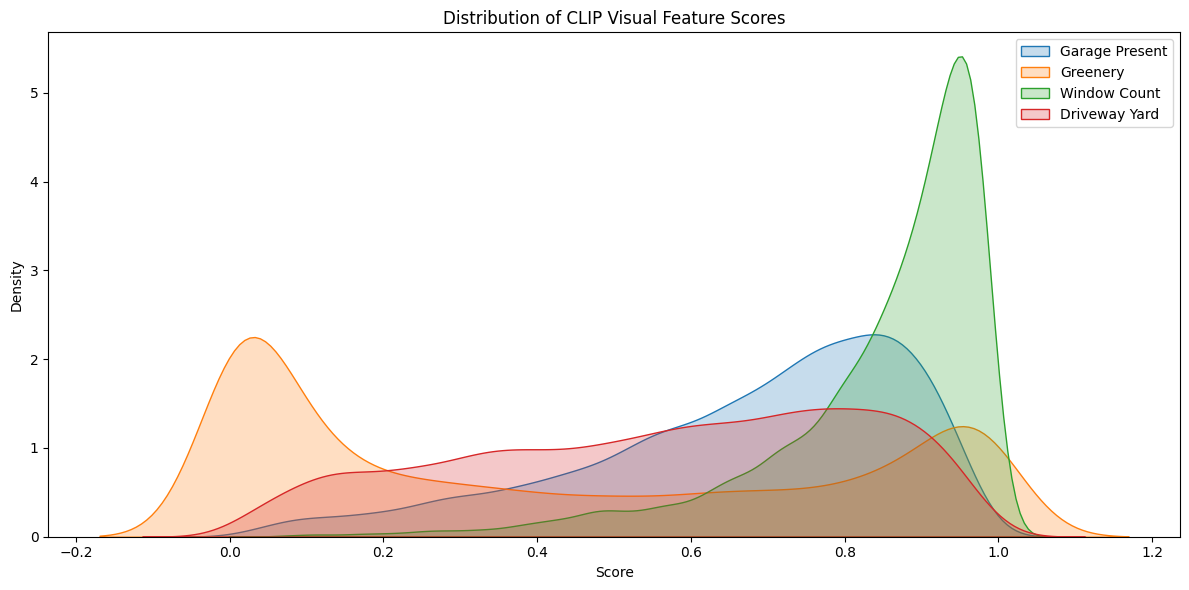

In [ ]:
def plot_all_clip_score_distributions(df):
    score_cols = [col for col in df.columns if col.endswith('_score')]
    plt.figure(figsize=(12, 6))

    for col in score_cols:
        sns.kdeplot(df[col], fill=True, label=col.replace('_score', '').replace('_', ' ').title())

    plt.title("Distribution of CLIP Visual Feature Scores")
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_all_clip_score_distributions(merged)


# **Preprocessing**

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12517 entries, 0 to 12516
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_id           12517 non-null  object 
 1   street_address        12517 non-null  object 
 2   city                  12517 non-null  object 
 3   city_encoded          12517 non-null  object 
 4   num_bedrooms          12517 non-null  object 
 5   num_bathrooms         12517 non-null  object 
 6   square_feet           12517 non-null  object 
 7   price                 12517 non-null  object 
 8   image_filename        12517 non-null  object 
 9   garage_present_score  12517 non-null  float64
 10  greenery_score        12517 non-null  float64
 11  window_count_score    12517 non-null  float64
 12  driveway_yard_score   12517 non-null  float64
dtypes: float64(4), object(9)
memory usage: 1.2+ MB


In [ ]:
# A plot to display missing values if any
def plot_missing_values(df):
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]

    if null_counts.empty:
        print("No missing values found.")
    else:
        plt.figure(figsize=(8, 4))
        bars = plt.barh(null_counts.index, null_counts.values, color='orange')
        for bar in bars:
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                     f'{int(bar.get_width())}', va='center')
        plt.title(f"Missing Values Per Column (Out of {len(df):,} rows)")
        plt.xlabel("Missing Count")
        plt.tight_layout()
        plt.show()

plot_missing_values(merged)


No missing values found.


In [ ]:
# Drop irrelevant columns
columns_to_drop = [
    "property_id",
    "street_address",
    "image_filename",
    "city_encoded"
]

df_cleaned = merged.drop(columns=columns_to_drop)

# Convert object columns to float
columns_to_convert = ['num_bedrooms', 'num_bathrooms', 'square_feet', 'price']
for col in columns_to_convert:
    df_cleaned[col] = (
        df_cleaned[col]
        .astype(str)
        .str.replace(",", "")  # just in case
        .str.strip()
    )
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Convert 'city' to categorical
df_cleaned['city'] = df_cleaned['city'].astype(str)
df_cleaned['city'] = pd.Categorical(df_cleaned['city'])

df['city'] = df['city'].astype(str)
df['city_encoded'] = LabelEncoder().fit_transform(df['city'])


# Drop rows with failed conversions
df_cleaned.dropna(subset=columns_to_convert, inplace=True)

print(df_cleaned.dtypes)
print("\n --------------------------------------------------------------------")
print(df_cleaned.head())


city                    category
num_bedrooms               int64
num_bathrooms            float64
square_feet                int64
price                      int64
garage_present_score     float64
greenery_score           float64
window_count_score       float64
driveway_yard_score      float64
dtype: object

 --------------------------------------------------------------------
           city  num_bedrooms  num_bathrooms  square_feet   price  \
0   Brawley, CA             3            2.0          713  228500   
1  Calexico, CA             4            3.0         2547  385100   
2  Calexico, CA             4            3.0         2769  415000   
3   Brawley, CA             5            2.1         2600  545000   
4   Brawley, CA             5            2.1         2600  545000   

   garage_present_score  greenery_score  window_count_score  \
0              0.511859        0.020464            0.658082   
1              0.941777        0.074924            0.979364   
2             

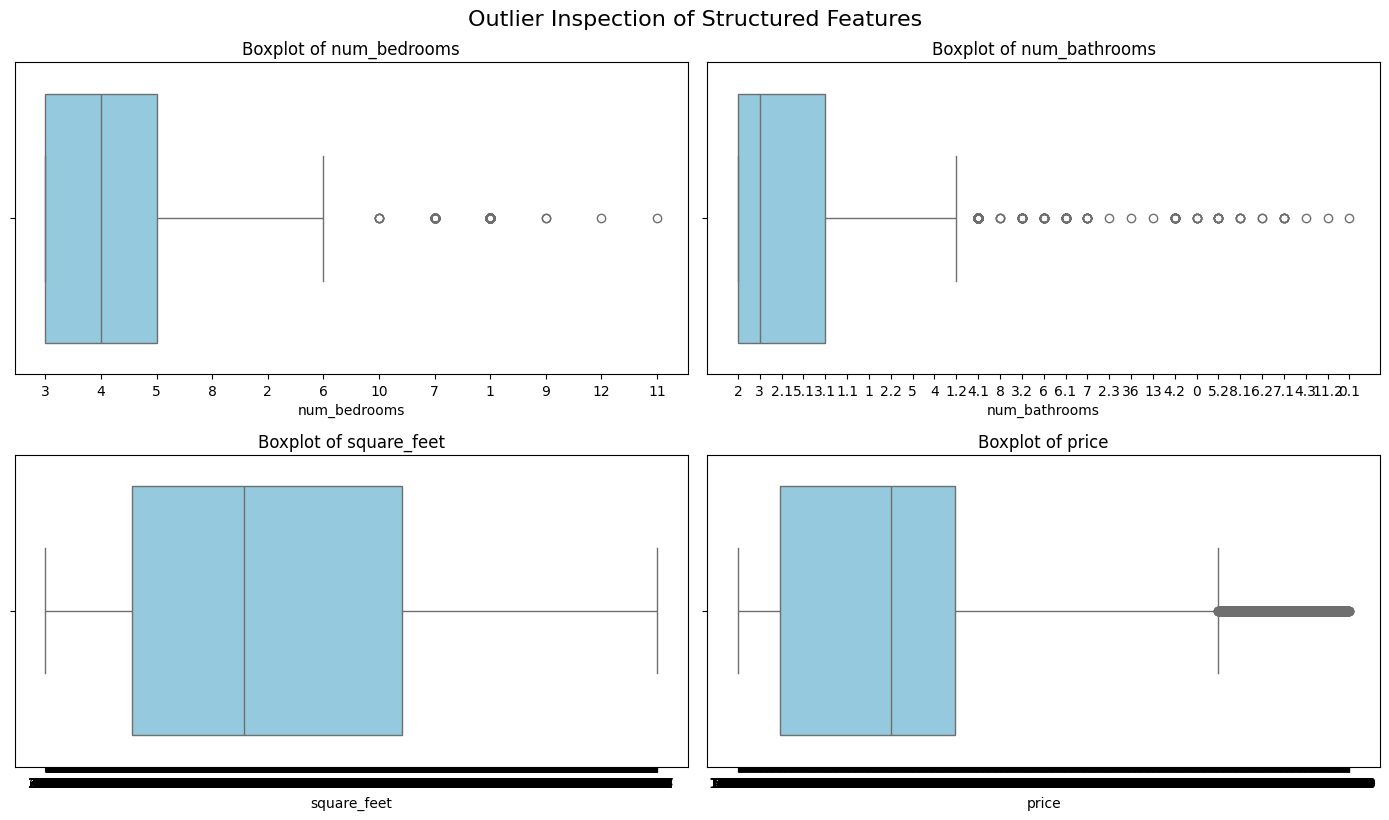

In [ ]:
# Features to inspect
num_features = ['num_bedrooms', 'num_bathrooms', 'square_feet', 'price']

# Set up plots
plt.figure(figsize=(14, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=merged[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()

plt.suptitle("Outlier Inspection of Structured Features", fontsize=16, y=1.02)
plt.show()


In [ ]:
# Define features and their respective cap percentiles according to outliers inspection
cap_rules = {
    'num_bedrooms': 0.95,
    'num_bathrooms': 0.90,
    'square_feet': 0.90
}

# Apply capping
for feature, percentile in cap_rules.items():
    cap = df_cleaned[feature].quantile(percentile)
    df_cleaned[feature] = np.where(df_cleaned[feature] > cap, cap, df_cleaned[feature])
    print(f"Capped {feature} at {percentile*100:.0f}th percentile: {cap:,.2f}")


Capped num_bedrooms at 95th percentile: 5.00
Capped num_bathrooms at 90th percentile: 4.00
Capped square_feet at 90th percentile: 3,538.00


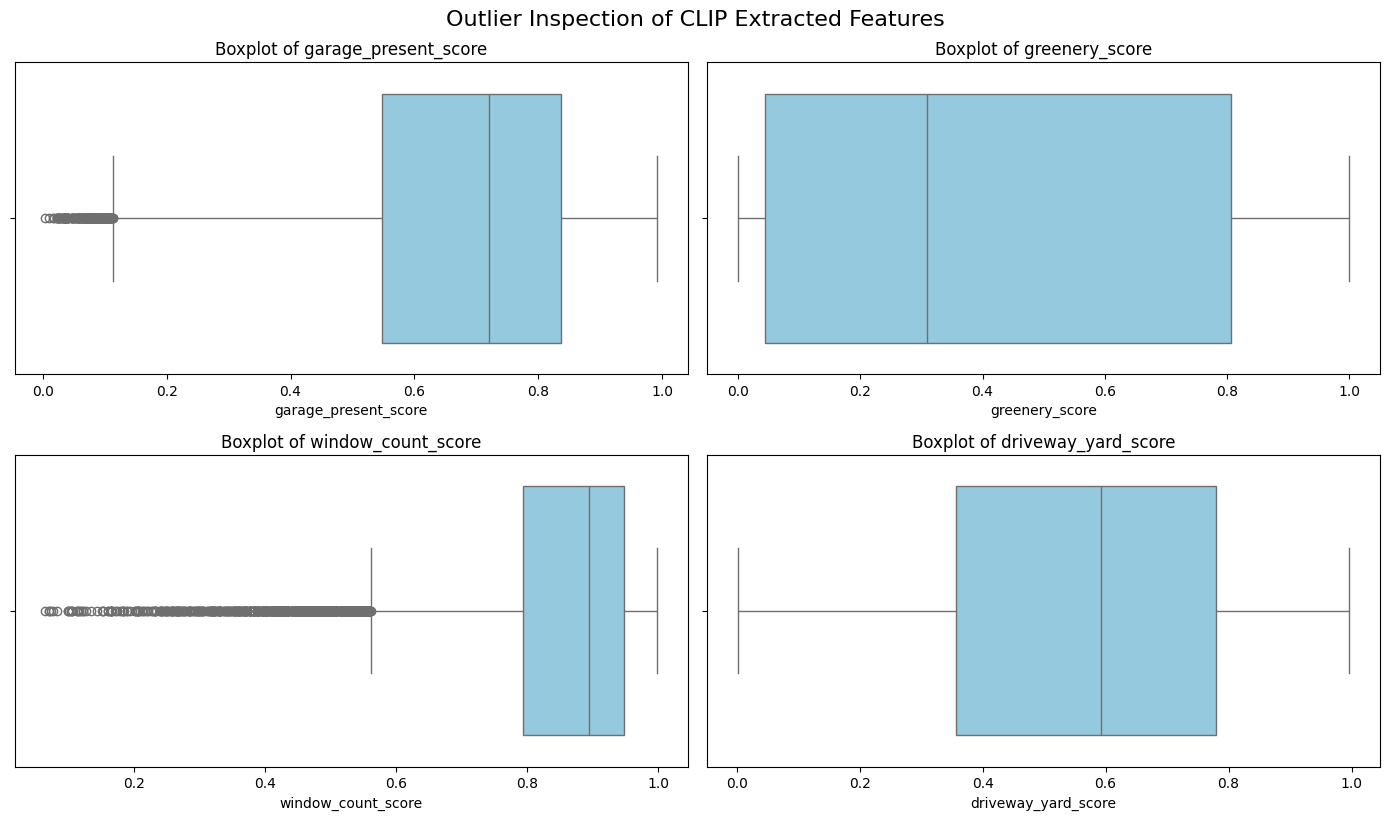

In [ ]:
# Features to inspect
num_features = ['garage_present_score', 'greenery_score', 'window_count_score', 'driveway_yard_score']

# Set up plots
plt.figure(figsize=(14, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=merged[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()

plt.suptitle("Outlier Inspection of CLIP Extracted Features", fontsize=16, y=1.02)
plt.show()


In [ ]:
# Define clipping and capping percentiles for score features
score_rules = {
    'garage_present_score': (0.05, 0.95),      # clip lower + cap upper
    'greenery_score': (0.01, 0.99),            # very minor, almost none
    'window_count_score': (0.20, 0.99),        # more aggressive lower clipping
    'driveway_yard_score': (0.01, 0.99)        # mild both sides
}

# Apply the clipped and capped features to df_cleaned
for feature, (low_pct, high_pct) in score_rules.items():
    lower = df_cleaned[feature].quantile(low_pct)
    upper = df_cleaned[feature].quantile(high_pct)
    df_cleaned[feature] = df_cleaned[feature].clip(lower=lower, upper=upper)
    print(f"Clipped {feature} between {low_pct*100:.0f}th and {high_pct*100:.0f}th percentiles")


Clipped garage_present_score between 5th and 95th percentiles
Clipped greenery_score between 1th and 99th percentiles
Clipped window_count_score between 20th and 99th percentiles
Clipped driveway_yard_score between 1th and 99th percentiles


In [ ]:
# Cap price outliers at 85th percentile
price_cap = df_cleaned['price'].quantile(0.85)
df_cleaned['price'] = np.where(df_cleaned['price'] > price_cap, price_cap, df_cleaned['price'])

print(f"Price values above ${price_cap:,.0f} have been capped.")


Price values above $968,895 have been capped.


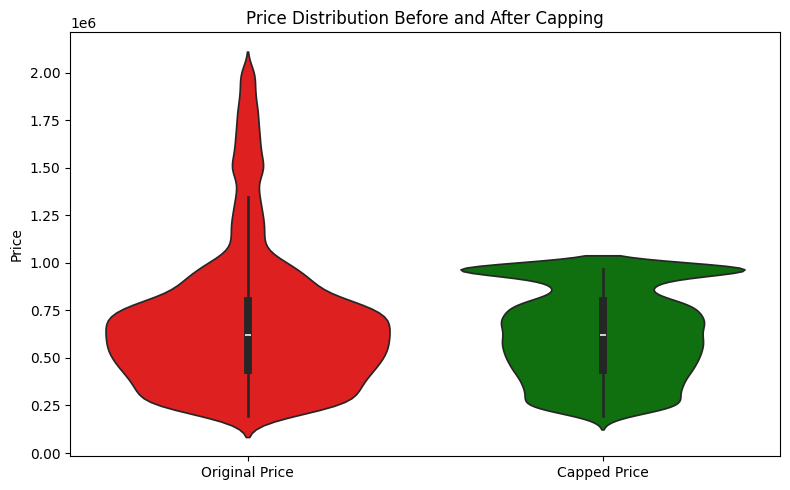

In [ ]:
def plot_price_violin(original_df, capped_df, price_column="price"):

    # Create a combined DataFrame for comparison
    df_viz = pd.DataFrame({
        "Original Price": original_df[price_column].astype(float),
        "Capped Price": capped_df[price_column]
    })

    # Melt for Seaborn
    df_melted = df_viz.melt(var_name="Stage", value_name="Price")

    # Plot
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Stage", y="Price", data=df_melted, palette=["red", "green"])
    plt.title("Price Distribution Before and After Capping")
    plt.ylabel("Price")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

plot_price_violin(merged, df_cleaned)


In [ ]:
# Define features to scale (numeric only, exclude categorical or object types)
features_to_scale = df_cleaned.select_dtypes(include=['int64', 'float64']).drop(columns=['price']).columns

# Apply scaling
scaler = StandardScaler()
df_cleaned[features_to_scale] = scaler.fit_transform(df_cleaned[features_to_scale])

# Target encode city using average price
city_price_map = df_cleaned.groupby('city')['price'].mean().to_dict()
df_cleaned['city_avg_price'] = df_cleaned['city'].map(city_price_map)

# Optionally drop the original city column
df_cleaned.drop(columns=['city'], inplace=True)


# Final split
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]


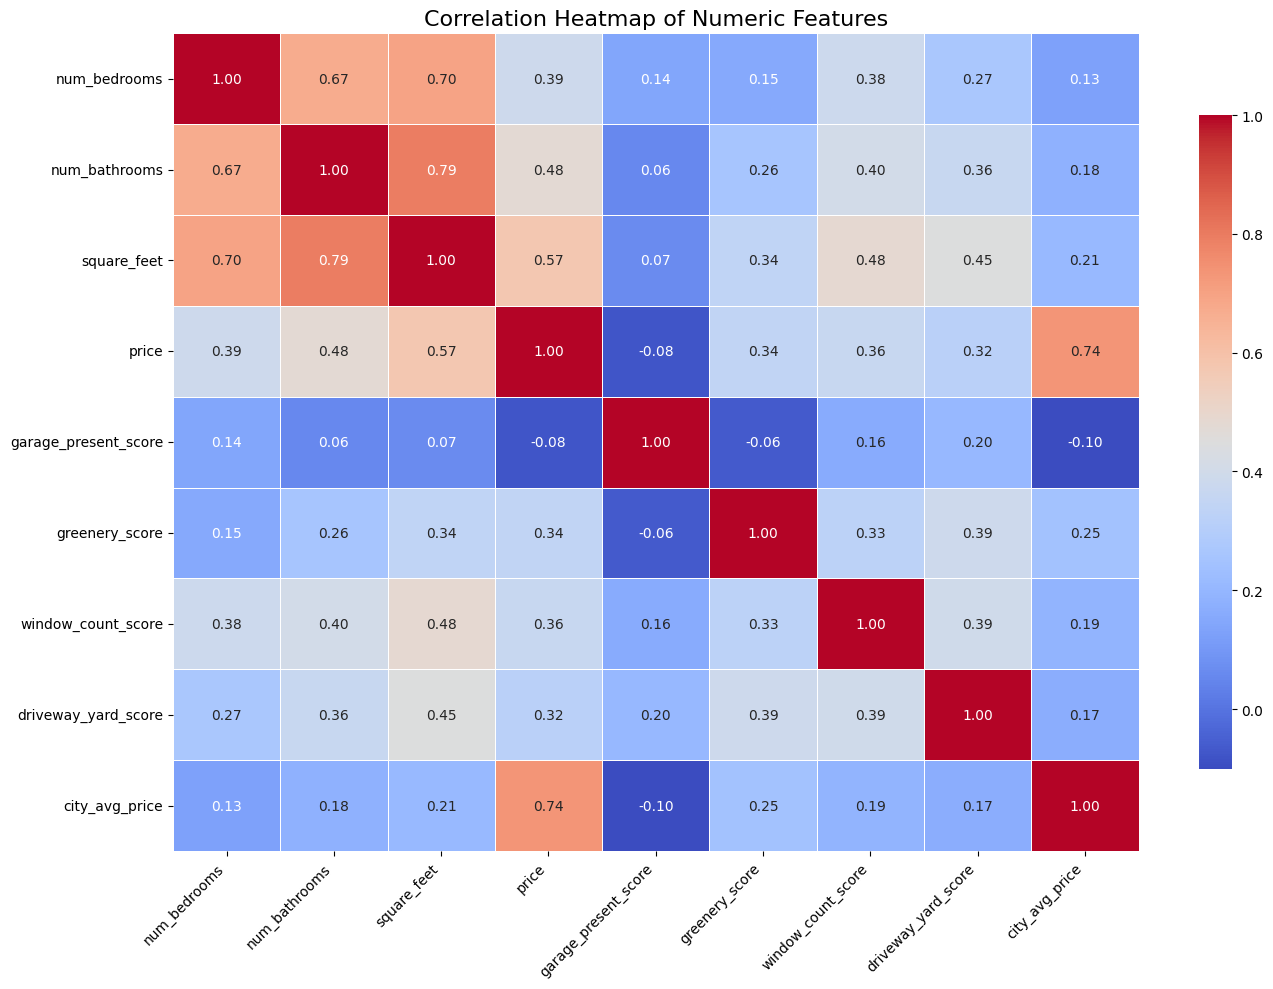

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    df_cleaned.select_dtypes(include=['number']).corr(),  # Only numeric features
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **Random Forest**

In [ ]:
# Binning target variable for stratification
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')

# Set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Base Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Cross-validation
cv_mae_rf_untuned = cross_val_score(rf_model, X, y, cv=skf.split(X, y_binned),
                               scoring=mae_scorer, n_jobs=-1)
cv_r2_rf_untuned = cross_val_score(rf_model, X, y, cv=skf.split(X, y_binned),
                              scoring='r2', n_jobs=-1)

print("\n StratifiedKFold (by price bins):")
print("\n MAE Scores:", -cv_mae_rf_untuned)
print(" \n R² Scores: ", cv_r2_rf_untuned)
print(f"\n Avg MAE: ${-np.mean(cv_mae_rf_untuned):,.2f}")
print(f" Avg R²: {np.mean(cv_r2_rf_untuned):.4f}")


 StratifiedKFold (by price bins):

 MAE Scores: [62524.94173661 65103.55817374 64988.6161869  62974.88494686
 64152.87684086]
 
 R² Scores:  [0.84083199 0.82794486 0.82617452 0.84792111 0.83422484]

 Avg MAE: $63,948.98
 Avg R²: 0.8354


In [ ]:
# Scorer setup
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Bin target for stratification
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Random Search Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.8, 1.0]
}

# Random Search CV Setup with StratifiedKFold
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    cv=skf.split(X, y_binned),
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit on full dataset
rf_random.fit(X, y)

# Best model
best_rf = rf_random.best_estimator_

# Cross Validation
cv_mae_rf_random = cross_val_score(best_rf, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_rf_random = cross_val_score(best_rf, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Random Search Tuned Random Forest with StratifiedKFold")
print("\n Best Hyperparameters:", rf_random.best_params_)
print("\n MAE Scores:", -cv_mae_rf_random)
print("\n R² Scores: ", cv_r2_rf_random)
print(f"\n Avg MAE: ${-np.mean(cv_mae_rf_random):,.2f}")
print(f"\n Avg R²: {np.mean(cv_r2_rf_random):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits

 5-Fold CV: Random Search Tuned Random Forest with StratifiedKFold

 Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}

 MAE Scores: [62464.67117493 64952.05441804 64645.88674826 62692.50169343
 63992.14970045]

 R² Scores:  [0.8412511  0.82812522 0.82774625 0.84948172 0.83474515]

 Avg MAE: $63,749.45

 Avg R²: 0.8363


In [ ]:
# Scorer setup
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Bin target for stratification
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search Hyperparameter Grid
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 0.8, 1]
}

# Grid Search CV Setup with StratifiedKFold
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=skf.split(X, y_binned),
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)


# Fit on full dataset
rf_grid.fit(X, y)

# Best model
best_rf = rf_grid.best_estimator_

# Final evaluation with StratifiedKFold
cv_mae_rf_grid = cross_val_score(best_rf, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_rf_grid = cross_val_score(best_rf, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Grid Search Tuned Random Forest with StratifiedKFold")
print("\n Best Hyperparameters:", rf_grid.best_params_)
print("\n MAE Scores:", -cv_mae_rf_grid)
print("\n R² Scores: ", cv_r2_rf_grid)
print(f"\n Avg MAE: ${-np.mean(cv_mae_rf_grid):,.2f}")
print(f"\n Avg R²: {np.mean(cv_r2_rf_grid):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

 5-Fold CV: Grid Search Tuned Random Forest with StratifiedKFold

 Best Hyperparameters: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 MAE Scores: [62375.67086723 67353.82712429 63056.70237475 64504.59721043
 65430.88830529]

 R² Scores:  [0.846916   0.82257377 0.83829464 0.83490716 0.82783736]

 Avg MAE: $64,544.34

 Avg R²: 0.8341


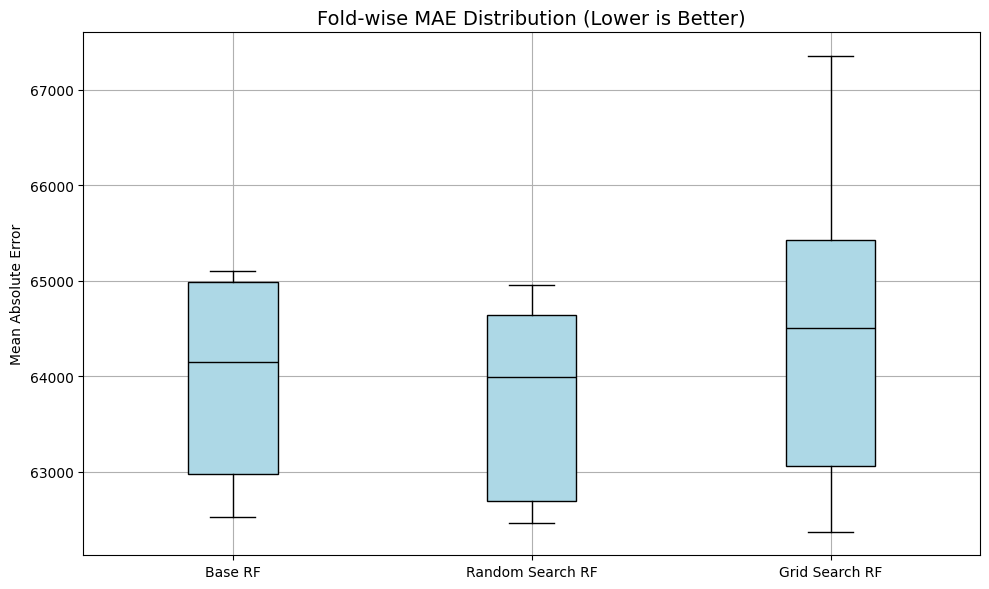

In [ ]:
# Convert negative MAE scores to positive
mae_strat = -cv_mae_rf_untuned
mae_rf_random = -cv_mae_rf_random
mae_rf_grid = -cv_mae_rf_grid

# Group MAE results
mae_data = [mae_strat, mae_rf_random, mae_rf_grid]
labels = ["Base RF", "Random Search RF", "Grid Search RF"]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(mae_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='black'))
plt.title("Fold-wise MAE Distribution (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


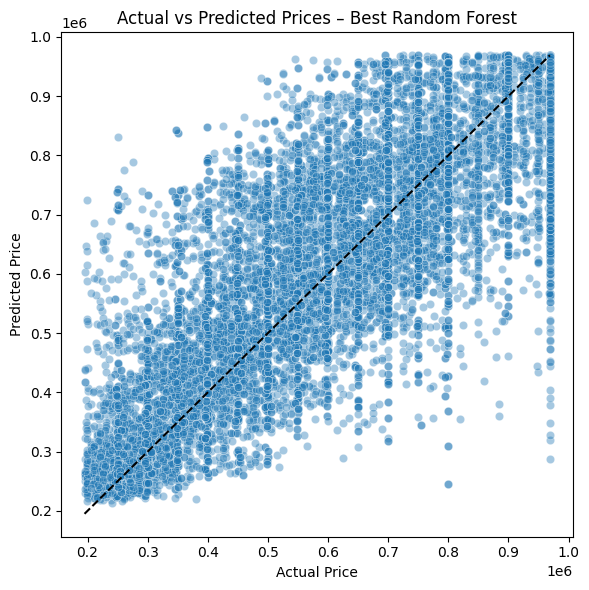

In [ ]:
# Actual vs Predicted Prices – Random Forest

def plot_actual_vs_predicted(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted Prices – {title}")
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(best_rf, X, y, "Best Random Forest")


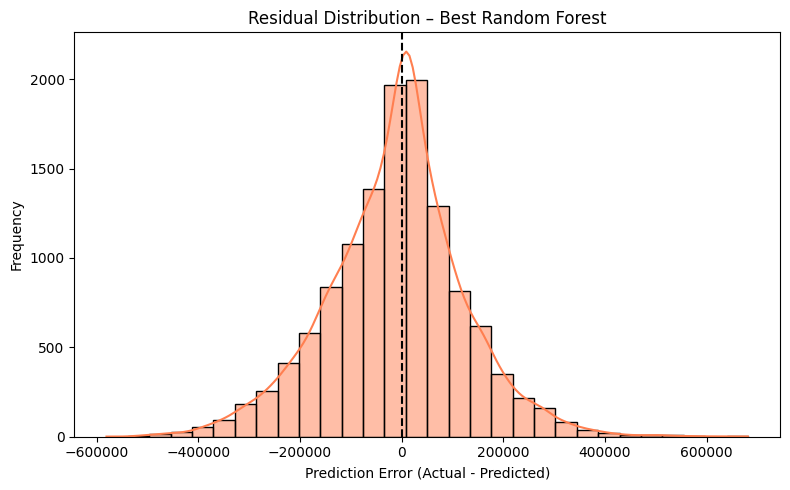

In [ ]:
# Residual Error Distribution – Random Forest

def plot_prediction_error(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    residuals = y - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color='coral')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Residual Distribution – {title}")
    plt.xlabel("Prediction Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_prediction_error(best_rf, X, y, "Best Random Forest")

In [ ]:
# Calculate the mean price
mean_price = np.mean(y)
print(f"Mean Price: ${mean_price:,.2f}")

# Function to calculate and print percentage MAE/price for each model
def print_mae_percentage(mae, model_name):
    percentage_mae = (mae / mean_price) * 100
    print(f"{model_name} MAE Percentage: {percentage_mae:.2f}%")

# Print MAE percentages for each model
print_mae_percentage(-np.mean(cv_mae_rf_untuned), "Base Random Forest")
print_mae_percentage(-np.mean(cv_mae_rf_random), "Random Search Tuned Random Forest")
print_mae_percentage(-np.mean(cv_mae_rf_grid), "Grid Search Tuned Random Forest")

Mean Price: $623,487.58
Base Random Forest MAE Percentage: 10.26%
Random Search Tuned Random Forest MAE Percentage: 10.22%
Grid Search Tuned Random Forest MAE Percentage: 10.35%


# **XGBoost**

In [ ]:
# Binning price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0
)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Cross-validation
cv_mae_xgb_untuned = cross_val_score(xgb, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_xgb_untuned = cross_val_score(xgb, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: XGBoost (untuned)")
print("\n MAE Scores:", -cv_mae_xgb_untuned)
print(" R² Scores: ", cv_r2_xgb_untuned)
print(f"\n Avg MAE: ${-np.mean(cv_mae_xgb_untuned):,.2f}")
print(f" Avg R²: {np.mean(cv_r2_xgb_untuned):.4f}")


 5-Fold CV: XGBoost (untuned)

 MAE Scores: [65083.81694414 70450.30589432 65230.56351503 67610.66103176
 67991.66685977]
 R² Scores:  [0.84572687 0.81884419 0.83798416 0.83211717 0.82796937]

 Avg MAE: $67,273.40
 Avg R²: 0.8325


In [ ]:
# Bin price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [4, 5, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Base model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

# RandomizedSearchCV with StratifiedKFold
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=skf.split(X, y_binned),
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit the model
xgb_random.fit(X, y)

# Best model
best_xgb = xgb_random.best_estimator_

# Cross Validation
cv_mae_xgb_random = cross_val_score(best_xgb, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_xgb_random = cross_val_score(best_xgb, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Random Search Tuned XGBoost with StratifiedKFold")
print("\n Best Hyperparameters:", xgb_random.best_params_)
print("\n MAE Scores:", -cv_mae_xgb_random)
print(" R² Scores: ", cv_r2_xgb_random)
print(f"\n Avg MAE: ${-np.mean(cv_mae_xgb_random):,.2f}")
print(f" Avg R²: {np.mean(cv_r2_xgb_random):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

 5-Fold CV: Random Search Tuned XGBoost with StratifiedKFold

 Best Hyperparameters: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

 MAE Scores: [58660.25709864 63527.7693453  58266.48893453 60182.1780863
 60377.85672193]
 R² Scores:  [0.85526788 0.82781743 0.85048037 0.84578383 0.84153388]

 Avg MAE: $60,202.91
 Avg R²: 0.8442


In [ ]:
# Bin price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Parameter grid
xgb_param_grid = {
    'n_estimators': [400, 450, 500],
    'learning_rate': [0.08, 0.1],
    'max_depth': [7, 8, 9],
    'subsample': [0.5 ,0.6],
    'colsample_bytree': [0.8, 0.7],
    'reg_alpha': [0.1, 1],
    'reg_lambda': [0.8, 2]
}

# Base model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV with StratifiedKFold
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=skf.split(X, y_binned),
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Fit the model
xgb_grid.fit(X, y)

# Best model
best_xgb = xgb_grid.best_estimator_

# Final evaluation using StratifiedKFold
cv_mae_xgb_grid = cross_val_score(best_xgb, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_xgb_grid = cross_val_score(best_xgb, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Grid Search Tuned XGBoost with StratifiedKFold")
print("\n Best Hyperparameters:", xgb_grid.best_params_)
print("\n MAE Scores:", -cv_mae_xgb_grid)
print("R² Scores: ", cv_r2_xgb_grid)
print(f"\n Avg MAE: ${-np.mean(cv_mae_xgb_grid):,.2f}")
print(f"Avg R²: {np.mean(cv_r2_xgb_grid):.4f}")


Fitting 5 folds for each of 288 candidates, totalling 1440 fits

 5-Fold CV: Grid Search Tuned XGBoost with StratifiedKFold

 Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 0.8, 'subsample': 0.6}

 MAE Scores: [55442.5186227  59898.77634909 54873.01777742 56993.88064947
 56972.66105673]
R² Scores:  [0.85688189 0.82951463 0.84993847 0.84344182 0.84146988]

 Avg MAE: $56,836.17
Avg R²: 0.8442


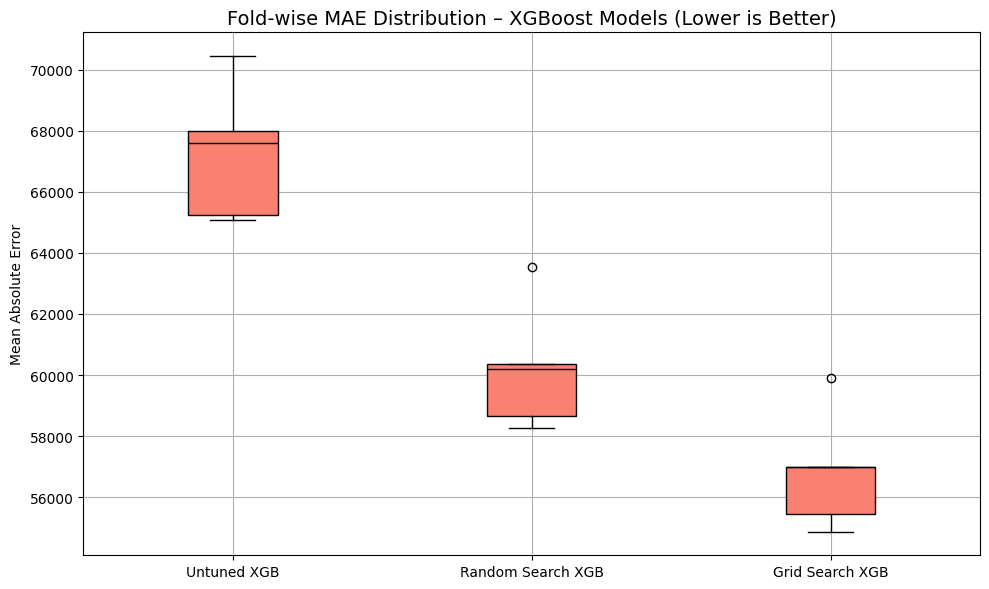

In [ ]:
# Convert to positive MAE values
mae_untuned = -cv_mae_xgb_untuned
mae_random = -cv_mae_xgb_random
mae_grid = -cv_mae_xgb_grid

# Combine for plotting
mae_data = [mae_untuned, mae_random, mae_grid]
labels = ["Untuned XGB", "Random Search XGB", "Grid Search XGB"]

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(mae_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='salmon'),
            medianprops=dict(color='black'))
plt.title("Fold-wise MAE Distribution – XGBoost Models (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

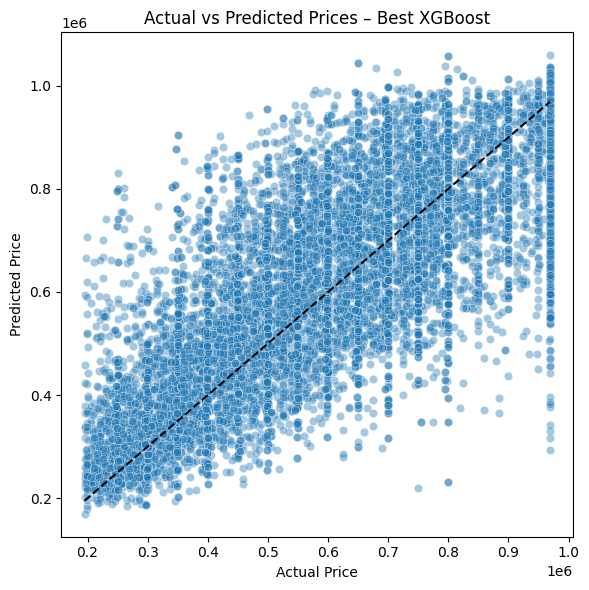

In [ ]:
# Actual vs Predicted Prices – Best XGBoost
from sklearn.model_selection import cross_val_predict

def plot_actual_vs_predicted(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted Prices – {title}")
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(best_xgb, X, y, "Best XGBoost")

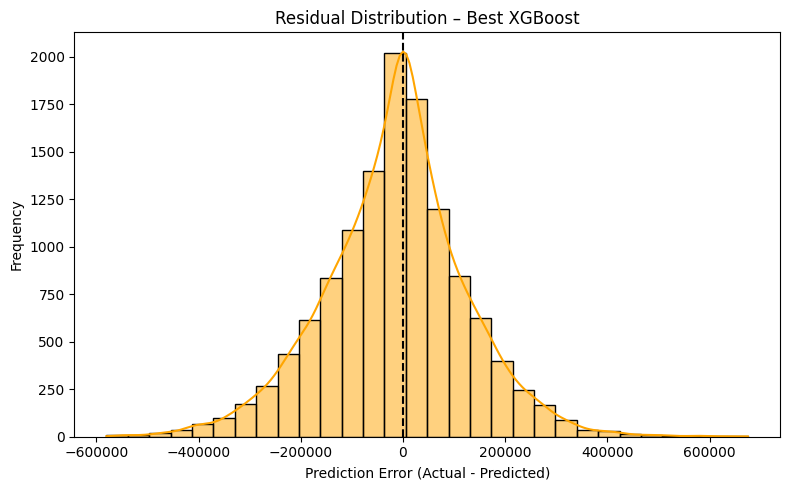

In [ ]:
# Residual Distribution – Best XGBoost

def plot_prediction_error(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    residuals = y - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color='orange')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Residual Distribution – {title}")
    plt.xlabel("Prediction Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_prediction_error(best_xgb, X, y, "Best XGBoost")

In [ ]:
# Calculate the mean price
mean_price = np.mean(y)
print(f"Mean Price: ${mean_price:,.2f}")

# Function to calculate and print percentage MAE/price for each model
def print_mae_percentage(mae, model_name):
    percentage_mae = (mae / mean_price) * 100
    print(f"{model_name} MAE Percentage: {percentage_mae:.2f}%")

print_mae_percentage(-np.mean(cv_mae_xgb_untuned), "XGBoost Stratified K-Fold (Untuned)")
print_mae_percentage(-np.mean(cv_mae_xgb_random), "Randomly Tuned XGBoost Stratified K-Fold")
print_mae_percentage(-np.mean(cv_mae_xgb_grid), "Grid Tuned XGBoost Stratified K-Fold")

Mean Price: $623,487.58
XGBoost Stratified K-Fold (Untuned) MAE Percentage: 10.79%
Randomly Tuned XGBoost Stratified K-Fold MAE Percentage: 9.66%
Grid Tuned XGBoost Stratified K-Fold MAE Percentage: 9.12%


# **Gradient Boost Algorithm with stratified k folds**

In [ ]:
# Bin price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Create and train the model
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Cross-validation
cv_mae_gbr_untuned = cross_val_score(gbr, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_gbr_untuned = cross_val_score(gbr, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Gradient Boosting Regressor with StratifiedKFold")
print("MAE Scores:", -cv_mae_gbr_untuned)
print("R² Scores: ", cv_r2_gbr_untuned)
print(f"Avg MAE: ${-np.mean(cv_mae_gbr_untuned):,.2f}")
print(f"Avg R²: {np.mean(cv_r2_gbr_untuned):.4f}")



 5-Fold CV: Gradient Boosting Regressor with StratifiedKFold
MAE Scores: [71483.9449442  76873.33290126 72197.21775397 75094.08850062
 76103.53273081]
R² Scores:  [0.82635173 0.79654142 0.81587828 0.80466512 0.79825494]
Avg MAE: $74,350.42
Avg R²: 0.8083


In [ ]:
# Bin price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Parameter grid
gbr_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Base model
gbr_base = GradientBoostingRegressor(random_state=42)

# RandomisedSearchCV with StratifiedKFold
gbr_random = RandomizedSearchCV(
    estimator=gbr_base,
    param_distributions=gbr_param_grid,
    n_iter=50,
    cv=skf.split(X, y_binned),
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

# Fit model
gbr_random.fit(X, y)

# Best model
best_gbr = gbr_random.best_estimator_

# Cross Validation
cv_mae_gbr_random = cross_val_score(best_gbr, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_gbr_random = cross_val_score(best_gbr, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)


# Output
print("\n 5-Fold CV: Random Search Tuned Gradient Boosting with StratifiedKFold")
print("\n Best Hyperparameters:", gbr_random.best_params_)
print("\n MAE Scores:", -cv_mae_gbr_random)
print(" R² Scores: ", cv_r2_gbr_random)
print(f"\n Avg MAE: ${-np.mean(cv_mae_gbr_random):,.2f}")
print(f" Avg R²: {np.mean(cv_r2_gbr_random):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits

 5-Fold CV: Random Search Tuned Gradient Boosting with StratifiedKFold

 Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 6, 'learning_rate': 0.1}

 MAE Scores: [63800.73660494 68255.99483501 64877.32668949 67091.47526795
 68349.57957881]
 R² Scores:  [0.8493964  0.8233685  0.83992843 0.83139831 0.82233016]

 Avg MAE: $66,475.02
 Avg R²: 0.8333


In [ ]:
# Bin price for stratified folds
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Parameter grid (Grid Search)
gbr_param_grid = {
    'n_estimators': [350, 400, 450],
    'learning_rate': [0.1, 0.2],
    'max_depth': [5, 6],
    'subsample': [0.8, 1.0],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2]
}

# Base model
gbr_base = GradientBoostingRegressor(random_state=42)

# GridSearchCV with StratifiedKFold
gbr_grid = GridSearchCV(
    estimator=gbr_base,
    param_grid=gbr_param_grid,
    cv=skf.split(X, y_binned),
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Fit model
gbr_grid.fit(X, y)

# Best model
best_gbr = gbr_grid.best_estimator_

# Final evaluation with StratifiedKFold
cv_mae_gbr_grid = cross_val_score(best_gbr, X, y, cv=skf.split(X, y_binned), scoring=mae_scorer, n_jobs=-1)
cv_r2_gbr_grid = cross_val_score(best_gbr, X, y, cv=skf.split(X, y_binned), scoring='r2', n_jobs=-1)

# Output
print("\n 5-Fold CV: Grid Search Tuned Gradient Boosting with StratifiedKFold")
print("\n Best Hyperparameters:", gbr_grid.best_params_)
print("\n MAE Scores:", -cv_mae_gbr_grid)
print("R² Scores: ", cv_r2_gbr_grid)
print(f"\n Avg MAE: ${-np.mean(cv_mae_gbr_grid):,.2f}")
print(f"Avg R²: {np.mean(cv_r2_gbr_grid):.4f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits

 5-Fold CV: Grid Search Tuned Gradient Boosting with StratifiedKFold

 Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 450, 'subsample': 1.0}

 MAE Scores: [60100.40704966 64459.07883289 60169.20396131 61448.99904996
 62316.4876694 ]
R² Scores:  [0.85330072 0.82563928 0.84751282 0.84072876 0.83624586]

 Avg MAE: $61,698.84
Avg R²: 0.8407


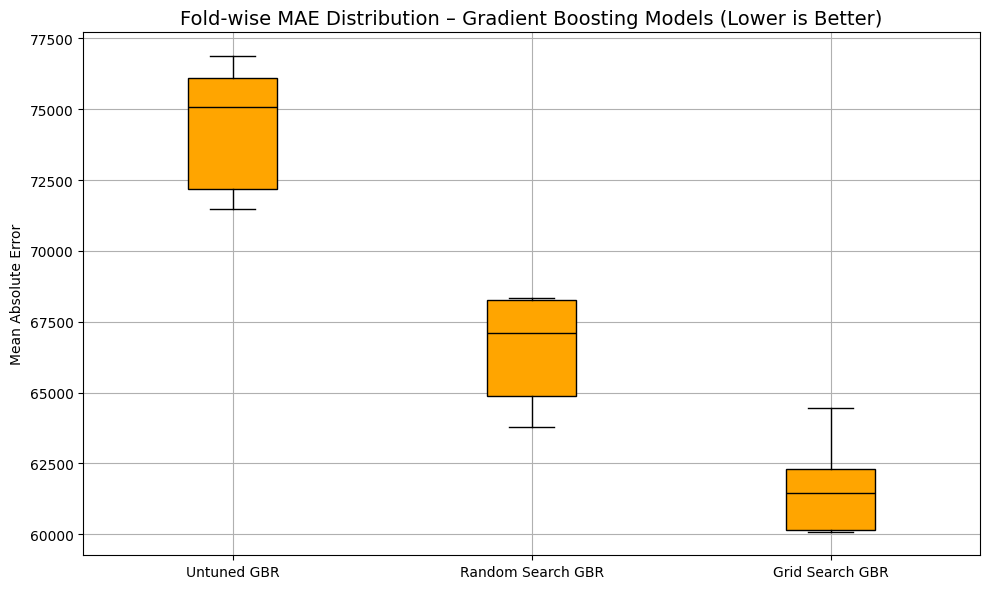

In [ ]:
# Convert to positive
mae_untuned = -cv_mae_gbr_untuned
mae_random = -cv_mae_gbr_random
mae_grid = -cv_mae_gbr_grid

# Combine for plotting
mae_data = [mae_untuned, mae_random, mae_grid]
labels = ["Untuned GBR", "Random Search GBR", "Grid Search GBR"]

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(mae_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='orange'),
            medianprops=dict(color='black'))
plt.title("Fold-wise MAE Distribution – Gradient Boosting Models (Lower is Better)", fontsize=14)
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


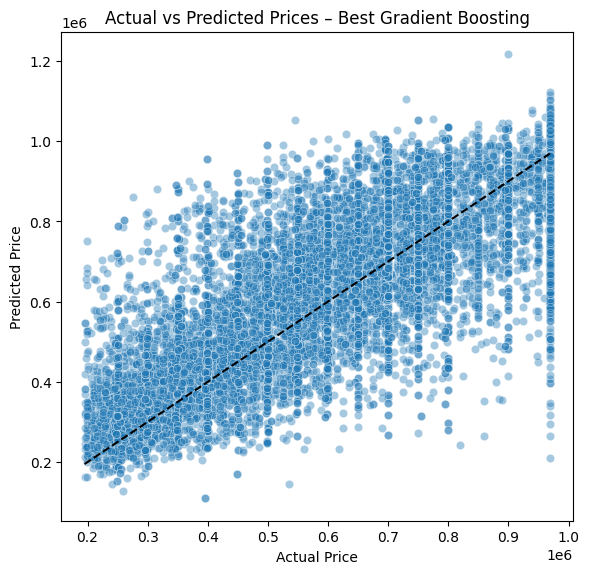

In [ ]:
# Actual vs Predicted – Best GBR
from sklearn.model_selection import cross_val_predict

def plot_actual_vs_predicted(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted Prices – {title}")
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(best_gbr, X, y, "Best Gradient Boosting")

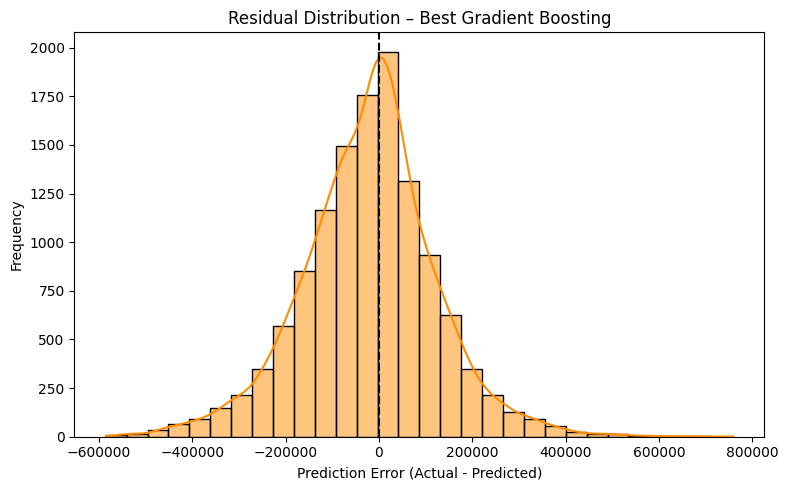

In [ ]:
# Residual Distribution – Best GBR

def plot_prediction_error(model, X, y, title):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
    residuals = y - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color='darkorange')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Residual Distribution – {title}")
    plt.xlabel("Prediction Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_prediction_error(best_gbr, X, y, "Best Gradient Boosting")


In [ ]:
# Calculate the mean price
mean_price = np.mean(y)
print(f"Mean Price: ${mean_price:,.2f}")

# Function to calculate and print percentage MAE/price for each model
def print_mae_percentage(mae, model_name):
    percentage_mae = (mae / mean_price) * 100
    print(f"{model_name} MAE Percentage: {percentage_mae:.2f}%")

print_mae_percentage(-np.mean(cv_mae_gbr_untuned), "Gradient Boosting Regressor Stratified K-Fold (Untuned)")
print_mae_percentage(-np.mean(cv_mae_gbr_random), "Random Search Tuned Gradient Boosting Stratified K-Fold")
print_mae_percentage(-np.mean(cv_mae_gbr_grid), "Grid Search Tuned Gradient Boosting Stratified K-Fold")


Mean Price: $623,487.58
Gradient Boosting Regressor Stratified K-Fold (Untuned) MAE Percentage: 11.92%
Random Search Tuned Gradient Boosting Stratified K-Fold MAE Percentage: 10.66%
Grid Search Tuned Gradient Boosting Stratified K-Fold MAE Percentage: 9.90%


# **Summary of Results**

In [ ]:
# Calculate the mean price
mean_price = np.mean(y)
print(f"Mean Price: ${mean_price:,.2f}")

# Function to calculate and print percentage MAE/price for each model
def print_mae_percentage(mae, model_name):
    percentage_mae = (mae / mean_price) * 100
    print(f"{model_name} MAE Percentage: {percentage_mae:.2f}%")

# Print MAE percentages for each model
print_mae_percentage(-np.mean(cv_mae_rf_untuned), "Base Random Forest")
print_mae_percentage(-np.mean(cv_mae_rf_random), "Random Search Tuned Random Forest")
print_mae_percentage(-np.mean(cv_mae_rf_grid), "Grid Search Tuned Random Forest")
print("------------------------------------------------------------------------")

print_mae_percentage(-np.mean(cv_mae_xgb_untuned), "XGBoost Stratified K-Fold (Untuned)")
print_mae_percentage(-np.mean(cv_mae_xgb_random), "Randomly Tuned XGBoost Stratified K-Fold")
print_mae_percentage(-np.mean(cv_mae_xgb_grid), "Grid Tuned XGBoost Stratified K-Fold")

print("------------------------------------------------------------------------")
print_mae_percentage(-np.mean(cv_mae_gbr_untuned), "Gradient Boosting Regressor Stratified K-Fold (Untuned)")
print_mae_percentage(-np.mean(cv_mae_gbr_random), "Random Search Tuned Gradient Boosting Stratified K-Fold")
print_mae_percentage(-np.mean(cv_mae_gbr_grid), "Grid Search Tuned Gradient Boosting Stratified K-Fold")



Mean Price: $623,487.58
Base Random Forest MAE Percentage: 10.26%
Random Search Tuned Random Forest MAE Percentage: 10.22%
Grid Search Tuned Random Forest MAE Percentage: 10.35%
------------------------------------------------------------------------
XGBoost Stratified K-Fold (Untuned) MAE Percentage: 10.79%
Randomly Tuned XGBoost Stratified K-Fold MAE Percentage: 9.66%
Grid Tuned XGBoost Stratified K-Fold MAE Percentage: 9.12%
------------------------------------------------------------------------
Gradient Boosting Regressor Stratified K-Fold (Untuned) MAE Percentage: 11.92%
Random Search Tuned Gradient Boosting Stratified K-Fold MAE Percentage: 10.66%
Grid Search Tuned Gradient Boosting Stratified K-Fold MAE Percentage: 9.90%


In [ ]:
results_summary = pd.DataFrame({
    "Model": ["Base RF", "Random Search RF", "Grid Search RF",
              "Untuned XGB", "Random Search XGB", "Grid Search XGB",
              "Untuned GBR", "Random Search GBR", "Grid Search GBR"],
    "Avg MAE": [mae_strat.mean(), mae_rf_random.mean(), mae_rf_grid.mean(),
                mae_untuned.mean(), mae_random.mean(), mae_grid.mean(),
                mae_untuned.mean(), mae_random.mean(), mae_grid.mean()],
    "R²": [cv_r2_rf_untuned.mean(), cv_r2_rf_random.mean(), cv_r2_rf_grid.mean(),
           cv_r2_xgb_untuned.mean(), cv_r2_xgb_random.mean(), cv_r2_xgb_grid.mean(),
           cv_r2_gbr_untuned.mean(), cv_r2_gbr_random.mean(), cv_r2_gbr_grid.mean()]
})
print(results_summary)


               Model       Avg MAE        R²
0            Base RF  63948.975577  0.835419
1   Random Search RF  63749.452747  0.836270
2     Grid Search RF  64544.337176  0.834106
3        Untuned XGB  74350.423366  0.832528
4  Random Search XGB  66475.022595  0.844177
5    Grid Search XGB  61698.835313  0.844249
6        Untuned GBR  74350.423366  0.808338
7  Random Search GBR  66475.022595  0.833284
8    Grid Search GBR  61698.835313  0.840685


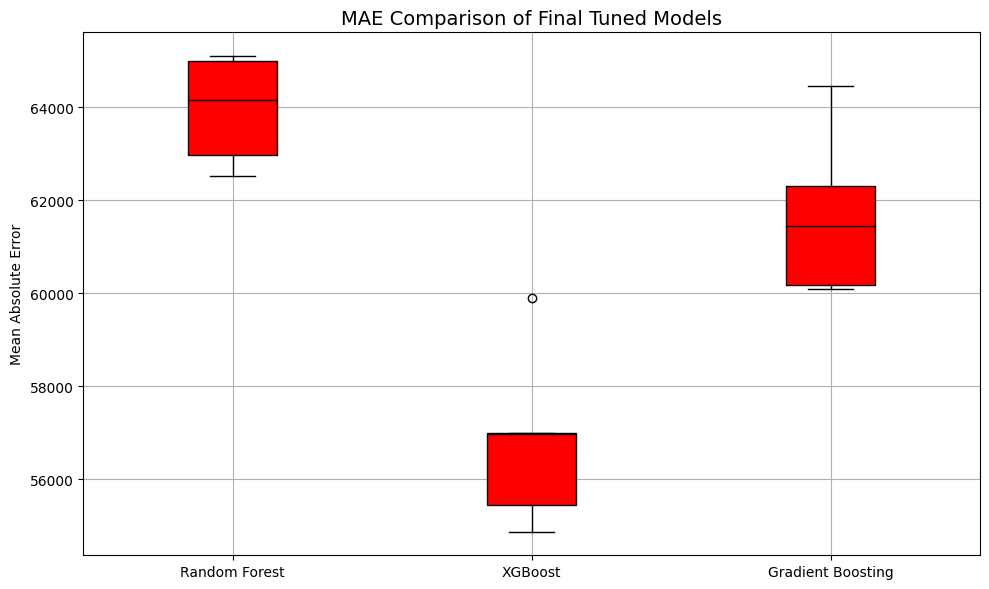

In [ ]:
# Convert to positive MAE scores
mae_rf = -cv_mae_rf_untuned
mae_xgb = -cv_mae_xgb_grid
mae_gbr = -cv_mae_gbr_grid

# Group all into one list
all_mae = [mae_rf, mae_xgb, mae_gbr]
labels = ["Random Forest", "XGBoost", "Gradient Boosting"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(all_mae, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='red'),
            medianprops=dict(color='black'))

# Titles and labels
plt.title("MAE Comparison of Final Tuned Models", fontsize=14)
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()
